In [46]:
import os
import sys
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
#from torchvision.datasets import CelebA
sys.path.append('../')

In [2]:
HOME=os.getenv("HOME")
dset = torchvision.datasets.CelebA(os.path.join(HOME, 'datasets'), 'train', 'attr', transform=transforms.ToTensor download=True)

Files already downloaded and verified


In [26]:
dset.attr_names.index('Smiling')

#dset.targets

31

In [17]:
from torch.utils.data import DataLoader


dl = DataLoader(dset, batch_size = 16)

iter(dl).next()

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [3]:
import requests

In [4]:
import sys
sys.executable


'/Users/daalvare/.pyenv/versions/jupyter3/bin/python'

In [49]:
import importlib
import src.icnn
importlib.reload(src.icnn)
from src.icnn import FICNN


predictor = FICNN(input_dim=d, hidden_dims=[100,100], dropout=0.1,nonlin='leaky_relu')

criterion = torch.nn.BCEWithLogitsLoss()


NameError: name 'd' is not defined

In [72]:
from torchvision.datasets import CelebA
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from torch.optim import SGD
import pytorch_lightning as pl
from pytorch_lightning.metrics import Accuracy
import sklearn
from sklearn.metrics import accuracy_score

from torch.nn import functional as F


def get_data_loaders(train_batch_size, val_batch_size):
    datadir = os.path.join(HOME, 'datasets')
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    attr_index = 31 # Do this programatically reading  ~/datasets/celeba/list_attr_celeba.txt
    target_transform = Lambda(lambda x: x[attr_index])
    train_loader = DataLoader(CelebA(root=datadir, split='test', transform=data_transform,
                                     target_transform=target_transform,
                                     download=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(CelebA(root=datadir, split='valid', transform=data_transform,
                                   target_transform=target_transform,
                                   download=True),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader



class FICNNBinClf(pl.LightningModule):

    def __init__(self):
        super(FICNNBinClf, self).__init__()
        self.model = FICNN(input_dim=3*218*178, hidden_dims=[100,100], dropout=0.1,nonlin='leaky_relu')

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))#torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        loss = F.binary_cross_entropy_with_logits(pred, y.view(y.size(0), 1).type_as(pred))
        acc  = accuracy_score(torch.sigmoid(pred.detach()).round().cpu(), y.cpu())
        tensorboard_logs = {'train_loss': loss, 'accuracy': acc}#Accuracy()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        loss = F.binary_cross_entropy_with_logits(pred, y.view(y.size(0), 1).type_as(pred))
        acc  = accuracy_score(torch.sigmoid(pred.detach()).round().cpu(), y.cpu())
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc  = np.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.02)


dlt, dlv = get_data_loaders(128,128)

model = FICNNBinClf()
trainer = pl.Trainer(progress_bar_refresh_rate=20)    
trainer.fit(model, dlt, dlv)  



Files already downloaded and verified
Files already downloaded and verified


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type  | Params
--------------------------------
0 | model | FICNN | 23 M  


[{'val_loss': tensor(1.5967), 'val_acc': 0.4921875}]


[{'val_loss': tensor(29.4264), 'val_acc': 0.5078125}, {'val_loss': tensor(26.4900), 'val_acc': 0.5625}, {'val_loss': tensor(31.5326), 'val_acc': 0.53125}, {'val_loss': tensor(28.6068), 'val_acc': 0.5625}, {'val_loss': tensor(26.0050), 'val_acc': 0.5234375}, {'val_loss': tensor(36.1183), 'val_acc': 0.4765625}, {'val_loss': tensor(102.5267), 'val_acc': 0.4375}, {'val_loss': tensor(29.6462), 'val_acc': 0.546875}, {'val_loss': tensor(28.0079), 'val_acc': 0.546875}, {'val_loss': tensor(30.8920), 'val_acc': 0.4921875}, {'val_loss': tensor(29.5372), 'val_acc': 0.53125}, {'val_loss': tensor(26.0924), 'val_acc': 0.578125}, {'val_loss': tensor(32.2803), 'val_acc': 0.4453125}, {'val_loss': tensor(194.5149), 'val_acc': 0.4453125}, {'val_loss': tensor(32.1377), 'val_acc': 0.46875}, {'val_loss': tensor(28.1422), 'val_acc': 0.546875}, {'val_loss': tensor(25.7158), 'val_acc': 0.5390625}, {'val_loss': tensor(26.1779), 'val_acc': 0.578125}, {'val_loss': tensor(27.7543), 'val_acc': 0.5}, {'val_loss': ten

[{'val_loss': tensor(49303.1797), 'val_acc': 0.5}, {'val_loss': tensor(20302.8672), 'val_acc': 0.5390625}, {'val_loss': tensor(57673.1367), 'val_acc': 0.4765625}, {'val_loss': tensor(25872.6094), 'val_acc': 0.5625}, {'val_loss': tensor(43245.5078), 'val_acc': 0.53125}, {'val_loss': tensor(49186.0234), 'val_acc': 0.4375}, {'val_loss': tensor(70600.6562), 'val_acc': 0.4140625}, {'val_loss': tensor(118256.1250), 'val_acc': 0.5078125}, {'val_loss': tensor(112470.9531), 'val_acc': 0.5}, {'val_loss': tensor(28613.3359), 'val_acc': 0.484375}, {'val_loss': tensor(57172.4453), 'val_acc': 0.5859375}, {'val_loss': tensor(86828.9531), 'val_acc': 0.5390625}, {'val_loss': tensor(51231.0664), 'val_acc': 0.4921875}, {'val_loss': tensor(14556.2061), 'val_acc': 0.484375}, {'val_loss': tensor(38175.9766), 'val_acc': 0.453125}, {'val_loss': tensor(6536.7383), 'val_acc': 0.53125}, {'val_loss': tensor(96299.4219), 'val_acc': 0.484375}, {'val_loss': tensor(29339.6250), 'val_acc': 0.5859375}, {'val_loss': ten

[{'val_loss': tensor(174.3796), 'val_acc': 0.5078125}, {'val_loss': tensor(168.8958), 'val_acc': 0.5625}, {'val_loss': tensor(937.1161), 'val_acc': 0.53125}, {'val_loss': tensor(170.1436), 'val_acc': 0.5625}, {'val_loss': tensor(134.4614), 'val_acc': 0.5234375}, {'val_loss': tensor(301.8689), 'val_acc': 0.4765625}, {'val_loss': tensor(1097.1301), 'val_acc': 0.4375}, {'val_loss': tensor(177.3339), 'val_acc': 0.546875}, {'val_loss': tensor(159.6777), 'val_acc': 0.546875}, {'val_loss': tensor(419.7743), 'val_acc': 0.4921875}, {'val_loss': tensor(168.3503), 'val_acc': 0.53125}, {'val_loss': tensor(150.3972), 'val_acc': 0.578125}, {'val_loss': tensor(202.6626), 'val_acc': 0.4453125}, {'val_loss': tensor(294.3522), 'val_acc': 0.4453125}, {'val_loss': tensor(1429.6816), 'val_acc': 0.46875}, {'val_loss': tensor(213.3278), 'val_acc': 0.546875}, {'val_loss': tensor(137.4576), 'val_acc': 0.5390625}, {'val_loss': tensor(160.9585), 'val_acc': 0.578125}, {'val_loss': tensor(148.4854), 'val_acc': 0.5

[{'val_loss': tensor(21829888.), 'val_acc': 0.3828125}, {'val_loss': tensor(14613504.), 'val_acc': 0.5078125}, {'val_loss': tensor(18303656.), 'val_acc': 0.578125}, {'val_loss': tensor(20767818.), 'val_acc': 0.4765625}, {'val_loss': tensor(22826316.), 'val_acc': 0.359375}, {'val_loss': tensor(30870150.), 'val_acc': 0.3671875}, {'val_loss': tensor(17905104.), 'val_acc': 0.453125}, {'val_loss': tensor(17958170.), 'val_acc': 0.4453125}, {'val_loss': tensor(13424875.), 'val_acc': 0.53125}, {'val_loss': tensor(22834772.), 'val_acc': 0.390625}, {'val_loss': tensor(26110472.), 'val_acc': 0.46875}, {'val_loss': tensor(19029224.), 'val_acc': 0.484375}, {'val_loss': tensor(24424948.), 'val_acc': 0.3828125}, {'val_loss': tensor(28518140.), 'val_acc': 0.4296875}, {'val_loss': tensor(22720636.), 'val_acc': 0.453125}, {'val_loss': tensor(18224972.), 'val_acc': 0.4140625}, {'val_loss': tensor(15785574.), 'val_acc': 0.453125}, {'val_loss': tensor(27340652.), 'val_acc': 0.484375}, {'val_loss': tensor(1

[{'val_loss': tensor(327787.6875), 'val_acc': 0.5078125}, {'val_loss': tensor(310801.0938), 'val_acc': 0.5625}, {'val_loss': tensor(362558.6562), 'val_acc': 0.53125}, {'val_loss': tensor(333894.3750), 'val_acc': 0.5625}, {'val_loss': tensor(267093.7188), 'val_acc': 0.5234375}, {'val_loss': tensor(354831.0312), 'val_acc': 0.4765625}, {'val_loss': tensor(754870.2500), 'val_acc': 0.4375}, {'val_loss': tensor(342538.8125), 'val_acc': 0.546875}, {'val_loss': tensor(308467.6250), 'val_acc': 0.546875}, {'val_loss': tensor(383958.1875), 'val_acc': 0.4921875}, {'val_loss': tensor(325185.8125), 'val_acc': 0.53125}, {'val_loss': tensor(297747.0625), 'val_acc': 0.578125}, {'val_loss': tensor(386784.6562), 'val_acc': 0.4453125}, {'val_loss': tensor(468680.2500), 'val_acc': 0.4453125}, {'val_loss': tensor(383467.5625), 'val_acc': 0.46875}, {'val_loss': tensor(318661.8750), 'val_acc': 0.546875}, {'val_loss': tensor(268084.4688), 'val_acc': 0.5390625}, {'val_loss': tensor(310905.6250), 'val_acc': 0.57

[{'val_loss': tensor(19022.9219), 'val_acc': 0.5546875}, {'val_loss': tensor(19889.2695), 'val_acc': 0.53125}, {'val_loss': tensor(21880.9102), 'val_acc': 0.5234375}, {'val_loss': tensor(37902.4102), 'val_acc': 0.5390625}, {'val_loss': tensor(41710.7344), 'val_acc': 0.515625}, {'val_loss': tensor(30805.2891), 'val_acc': 0.4765625}, {'val_loss': tensor(66417.3203), 'val_acc': 0.5}, {'val_loss': tensor(27973.6055), 'val_acc': 0.484375}, {'val_loss': tensor(29101.0391), 'val_acc': 0.5078125}, {'val_loss': tensor(20269.0527), 'val_acc': 0.4453125}, {'val_loss': tensor(8059.7412), 'val_acc': 0.5859375}, {'val_loss': tensor(41047.3438), 'val_acc': 0.5390625}, {'val_loss': tensor(28311.5059), 'val_acc': 0.4375}, {'val_loss': tensor(20004.0254), 'val_acc': 0.4765625}, {'val_loss': tensor(18682.2012), 'val_acc': 0.5}, {'val_loss': tensor(21868.4551), 'val_acc': 0.5703125}, {'val_loss': tensor(19249.2031), 'val_acc': 0.5546875}, {'val_loss': tensor(29423.6074), 'val_acc': 0.5625}, {'val_loss': t

[{'val_loss': tensor(33300.4727), 'val_acc': 0.5078125}, {'val_loss': tensor(31462.8867), 'val_acc': 0.5625}, {'val_loss': tensor(36562.6133), 'val_acc': 0.53125}, {'val_loss': tensor(33774.9609), 'val_acc': 0.5625}, {'val_loss': tensor(27455.3945), 'val_acc': 0.5234375}, {'val_loss': tensor(37586.6953), 'val_acc': 0.4765625}, {'val_loss': tensor(95460.3281), 'val_acc': 0.4375}, {'val_loss': tensor(34978.7109), 'val_acc': 0.546875}, {'val_loss': tensor(31381.1406), 'val_acc': 0.546875}, {'val_loss': tensor(38817.1992), 'val_acc': 0.4921875}, {'val_loss': tensor(32899.6367), 'val_acc': 0.53125}, {'val_loss': tensor(30461.8281), 'val_acc': 0.578125}, {'val_loss': tensor(39258.2578), 'val_acc': 0.4453125}, {'val_loss': tensor(47460.6367), 'val_acc': 0.4453125}, {'val_loss': tensor(39167.9375), 'val_acc': 0.46875}, {'val_loss': tensor(32472.8594), 'val_acc': 0.546875}, {'val_loss': tensor(27466.5332), 'val_acc': 0.5390625}, {'val_loss': tensor(31690.8770), 'val_acc': 0.578125}, {'val_loss'

[{'val_loss': tensor(3613.2529), 'val_acc': 0.5078125}, {'val_loss': tensor(3543.7573), 'val_acc': 0.5625}, {'val_loss': tensor(4242.1748), 'val_acc': 0.53125}, {'val_loss': tensor(3979.9026), 'val_acc': 0.5625}, {'val_loss': tensor(3297.9282), 'val_acc': 0.5234375}, {'val_loss': tensor(5415.1787), 'val_acc': 0.4765625}, {'val_loss': tensor(42320.0195), 'val_acc': 0.4375}, {'val_loss': tensor(4211.7368), 'val_acc': 0.546875}, {'val_loss': tensor(3719.4775), 'val_acc': 0.546875}, {'val_loss': tensor(4555.3750), 'val_acc': 0.4921875}, {'val_loss': tensor(3736.6309), 'val_acc': 0.53125}, {'val_loss': tensor(3662.6472), 'val_acc': 0.578125}, {'val_loss': tensor(4620.8516), 'val_acc': 0.4453125}, {'val_loss': tensor(5580.2808), 'val_acc': 0.4453125}, {'val_loss': tensor(4625.9365), 'val_acc': 0.46875}, {'val_loss': tensor(3535.1685), 'val_acc': 0.546875}, {'val_loss': tensor(3398.9304), 'val_acc': 0.5390625}, {'val_loss': tensor(3757.4617), 'val_acc': 0.578125}, {'val_loss': tensor(4078.420

[{'val_loss': tensor(6691.9395), 'val_acc': 0.5078125}, {'val_loss': tensor(5307.5640), 'val_acc': 0.5625}, {'val_loss': tensor(7096.9077), 'val_acc': 0.53125}, {'val_loss': tensor(6798.7070), 'val_acc': 0.5625}, {'val_loss': tensor(6073.6895), 'val_acc': 0.5234375}, {'val_loss': tensor(6886.8848), 'val_acc': 0.4765625}, {'val_loss': tensor(34730.0273), 'val_acc': 0.4375}, {'val_loss': tensor(6648.1250), 'val_acc': 0.546875}, {'val_loss': tensor(6036.0400), 'val_acc': 0.546875}, {'val_loss': tensor(7551.2812), 'val_acc': 0.4921875}, {'val_loss': tensor(5945.2505), 'val_acc': 0.53125}, {'val_loss': tensor(5288.9409), 'val_acc': 0.578125}, {'val_loss': tensor(8190.4199), 'val_acc': 0.4453125}, {'val_loss': tensor(9103.7676), 'val_acc': 0.4453125}, {'val_loss': tensor(7764.1968), 'val_acc': 0.46875}, {'val_loss': tensor(5275.0684), 'val_acc': 0.546875}, {'val_loss': tensor(6123.0088), 'val_acc': 0.5390625}, {'val_loss': tensor(6772.3774), 'val_acc': 0.578125}, {'val_loss': tensor(5854.075

[{'val_loss': tensor(1241.3280), 'val_acc': 0.7421875}, {'val_loss': tensor(4203.0122), 'val_acc': 0.7734375}, {'val_loss': tensor(4495.6445), 'val_acc': 0.6640625}, {'val_loss': tensor(5208.9111), 'val_acc': 0.703125}, {'val_loss': tensor(1379.1582), 'val_acc': 0.765625}, {'val_loss': tensor(8034.5254), 'val_acc': 0.671875}, {'val_loss': tensor(26432.3750), 'val_acc': 0.671875}, {'val_loss': tensor(6068.0059), 'val_acc': 0.6640625}, {'val_loss': tensor(958.4509), 'val_acc': 0.7734375}, {'val_loss': tensor(2746.1187), 'val_acc': 0.7265625}, {'val_loss': tensor(6036.2095), 'val_acc': 0.75}, {'val_loss': tensor(1706.6659), 'val_acc': 0.7109375}, {'val_loss': tensor(4921.2202), 'val_acc': 0.65625}, {'val_loss': tensor(4080.5332), 'val_acc': 0.671875}, {'val_loss': tensor(3762.7251), 'val_acc': 0.6484375}, {'val_loss': tensor(7064.8003), 'val_acc': 0.7734375}, {'val_loss': tensor(6353.6162), 'val_acc': 0.6015625}, {'val_loss': tensor(6072.4717), 'val_acc': 0.6953125}, {'val_loss': tensor(5

[{'val_loss': tensor(26142.9434), 'val_acc': 0.5078125}, {'val_loss': tensor(24458.9023), 'val_acc': 0.5625}, {'val_loss': tensor(29000.5840), 'val_acc': 0.53125}, {'val_loss': tensor(26255.3164), 'val_acc': 0.5625}, {'val_loss': tensor(21546.9902), 'val_acc': 0.5234375}, {'val_loss': tensor(29933.2305), 'val_acc': 0.4765625}, {'val_loss': tensor(61052.8477), 'val_acc': 0.4375}, {'val_loss': tensor(27077.9297), 'val_acc': 0.546875}, {'val_loss': tensor(24340.6816), 'val_acc': 0.546875}, {'val_loss': tensor(30231.7500), 'val_acc': 0.4921875}, {'val_loss': tensor(25717.5508), 'val_acc': 0.53125}, {'val_loss': tensor(24248.3184), 'val_acc': 0.578125}, {'val_loss': tensor(30583.0508), 'val_acc': 0.4453125}, {'val_loss': tensor(37273.8008), 'val_acc': 0.4453125}, {'val_loss': tensor(31875.8691), 'val_acc': 0.46875}, {'val_loss': tensor(24947.8418), 'val_acc': 0.546875}, {'val_loss': tensor(22089.1797), 'val_acc': 0.5390625}, {'val_loss': tensor(25007.4004), 'val_acc': 0.578125}, {'val_loss'

[{'val_loss': tensor(1307.7229), 'val_acc': 0.609375}, {'val_loss': tensor(927.9778), 'val_acc': 0.6875}, {'val_loss': tensor(2544.8113), 'val_acc': 0.625}, {'val_loss': tensor(1111.1260), 'val_acc': 0.703125}, {'val_loss': tensor(817.9302), 'val_acc': 0.7421875}, {'val_loss': tensor(3340.4189), 'val_acc': 0.578125}, {'val_loss': tensor(40576.9102), 'val_acc': 0.5859375}, {'val_loss': tensor(1379.6298), 'val_acc': 0.703125}, {'val_loss': tensor(929.1217), 'val_acc': 0.6796875}, {'val_loss': tensor(1818.3711), 'val_acc': 0.578125}, {'val_loss': tensor(1265.0754), 'val_acc': 0.6875}, {'val_loss': tensor(1016.3851), 'val_acc': 0.65625}, {'val_loss': tensor(1570.9207), 'val_acc': 0.59375}, {'val_loss': tensor(2840.6677), 'val_acc': 0.578125}, {'val_loss': tensor(1210.1526), 'val_acc': 0.5859375}, {'val_loss': tensor(1166.0461), 'val_acc': 0.7265625}, {'val_loss': tensor(1230.3303), 'val_acc': 0.703125}, {'val_loss': tensor(1519.8811), 'val_acc': 0.6953125}, {'val_loss': tensor(996.6141), '

[{'val_loss': tensor(2594.6292), 'val_acc': 0.5078125}, {'val_loss': tensor(2376.1826), 'val_acc': 0.5625}, {'val_loss': tensor(2825.7632), 'val_acc': 0.546875}, {'val_loss': tensor(2719.3877), 'val_acc': 0.5625}, {'val_loss': tensor(2305.8208), 'val_acc': 0.5234375}, {'val_loss': tensor(4305.0186), 'val_acc': 0.4765625}, {'val_loss': tensor(27630.4180), 'val_acc': 0.4453125}, {'val_loss': tensor(2802.5447), 'val_acc': 0.546875}, {'val_loss': tensor(2390.1836), 'val_acc': 0.546875}, {'val_loss': tensor(3244.5757), 'val_acc': 0.4921875}, {'val_loss': tensor(2389.8989), 'val_acc': 0.53125}, {'val_loss': tensor(2644.6665), 'val_acc': 0.578125}, {'val_loss': tensor(3011.3193), 'val_acc': 0.4453125}, {'val_loss': tensor(4379.6040), 'val_acc': 0.453125}, {'val_loss': tensor(3146.3579), 'val_acc': 0.4765625}, {'val_loss': tensor(2307.6248), 'val_acc': 0.5546875}, {'val_loss': tensor(2264.8423), 'val_acc': 0.546875}, {'val_loss': tensor(2570.3955), 'val_acc': 0.578125}, {'val_loss': tensor(248

[{'val_loss': tensor(5023.9951), 'val_acc': 0.8046875}, {'val_loss': tensor(9146.0459), 'val_acc': 0.875}, {'val_loss': tensor(4873.0654), 'val_acc': 0.78125}, {'val_loss': tensor(7619.9546), 'val_acc': 0.796875}, {'val_loss': tensor(4326.3276), 'val_acc': 0.78125}, {'val_loss': tensor(8226.9385), 'val_acc': 0.7890625}, {'val_loss': tensor(21327.5527), 'val_acc': 0.7734375}, {'val_loss': tensor(7953.0840), 'val_acc': 0.78125}, {'val_loss': tensor(2490.7690), 'val_acc': 0.8125}, {'val_loss': tensor(7304.4961), 'val_acc': 0.78125}, {'val_loss': tensor(7925.9609), 'val_acc': 0.8125}, {'val_loss': tensor(3700.1611), 'val_acc': 0.7890625}, {'val_loss': tensor(8512.9463), 'val_acc': 0.7578125}, {'val_loss': tensor(3857.4971), 'val_acc': 0.828125}, {'val_loss': tensor(8458.8877), 'val_acc': 0.75}, {'val_loss': tensor(9912.2686), 'val_acc': 0.8359375}, {'val_loss': tensor(9960.6689), 'val_acc': 0.7578125}, {'val_loss': tensor(7633.1157), 'val_acc': 0.796875}, {'val_loss': tensor(6451.9937), 'v

[{'val_loss': tensor(3866.2568), 'val_acc': 0.5078125}, {'val_loss': tensor(3377.2500), 'val_acc': 0.5625}, {'val_loss': tensor(3943.7070), 'val_acc': 0.53125}, {'val_loss': tensor(3883.0854), 'val_acc': 0.5625}, {'val_loss': tensor(3046.0315), 'val_acc': 0.5234375}, {'val_loss': tensor(5102.1030), 'val_acc': 0.484375}, {'val_loss': tensor(19107.6934), 'val_acc': 0.4453125}, {'val_loss': tensor(3925.0386), 'val_acc': 0.5546875}, {'val_loss': tensor(3334.7573), 'val_acc': 0.546875}, {'val_loss': tensor(5458.4961), 'val_acc': 0.4921875}, {'val_loss': tensor(3339.1753), 'val_acc': 0.5390625}, {'val_loss': tensor(3558.0596), 'val_acc': 0.578125}, {'val_loss': tensor(4186.5771), 'val_acc': 0.453125}, {'val_loss': tensor(6203.8926), 'val_acc': 0.4453125}, {'val_loss': tensor(4434.0581), 'val_acc': 0.4765625}, {'val_loss': tensor(3405.9971), 'val_acc': 0.546875}, {'val_loss': tensor(3132.5569), 'val_acc': 0.546875}, {'val_loss': tensor(3618.5027), 'val_acc': 0.578125}, {'val_loss': tensor(328

[{'val_loss': tensor(3520.2412), 'val_acc': 0.5078125}, {'val_loss': tensor(3002.2795), 'val_acc': 0.5703125}, {'val_loss': tensor(3580.1780), 'val_acc': 0.53125}, {'val_loss': tensor(3553.8447), 'val_acc': 0.5625}, {'val_loss': tensor(2685.1521), 'val_acc': 0.5234375}, {'val_loss': tensor(4758.2695), 'val_acc': 0.484375}, {'val_loss': tensor(18070.1055), 'val_acc': 0.4453125}, {'val_loss': tensor(3587.3152), 'val_acc': 0.5546875}, {'val_loss': tensor(3075.0461), 'val_acc': 0.546875}, {'val_loss': tensor(5925.1162), 'val_acc': 0.4921875}, {'val_loss': tensor(3020.5918), 'val_acc': 0.546875}, {'val_loss': tensor(3307.1570), 'val_acc': 0.578125}, {'val_loss': tensor(3796.7795), 'val_acc': 0.453125}, {'val_loss': tensor(5949.4365), 'val_acc': 0.4453125}, {'val_loss': tensor(3927.8691), 'val_acc': 0.4765625}, {'val_loss': tensor(3045.2051), 'val_acc': 0.546875}, {'val_loss': tensor(2777.3137), 'val_acc': 0.546875}, {'val_loss': tensor(3329.6523), 'val_acc': 0.578125}, {'val_loss': tensor(3

[{'val_loss': tensor(11534.6631), 'val_acc': 0.5078125}, {'val_loss': tensor(10593.2109), 'val_acc': 0.5625}, {'val_loss': tensor(12271.9521), 'val_acc': 0.53125}, {'val_loss': tensor(11526.9160), 'val_acc': 0.5625}, {'val_loss': tensor(9571.7637), 'val_acc': 0.5234375}, {'val_loss': tensor(13301.7793), 'val_acc': 0.4765625}, {'val_loss': tensor(28659.8301), 'val_acc': 0.4375}, {'val_loss': tensor(11901.9902), 'val_acc': 0.546875}, {'val_loss': tensor(10640.5117), 'val_acc': 0.546875}, {'val_loss': tensor(13543.5820), 'val_acc': 0.4921875}, {'val_loss': tensor(11025.6689), 'val_acc': 0.53125}, {'val_loss': tensor(10580.1689), 'val_acc': 0.578125}, {'val_loss': tensor(13302.7168), 'val_acc': 0.4453125}, {'val_loss': tensor(16783.7734), 'val_acc': 0.4453125}, {'val_loss': tensor(13343.5312), 'val_acc': 0.46875}, {'val_loss': tensor(10849.2256), 'val_acc': 0.546875}, {'val_loss': tensor(9337.7666), 'val_acc': 0.5390625}, {'val_loss': tensor(10822.2295), 'val_acc': 0.578125}, {'val_loss': 

[{'val_loss': tensor(1321.9921), 'val_acc': 0.5390625}, {'val_loss': tensor(878.7045), 'val_acc': 0.6171875}, {'val_loss': tensor(1082.3828), 'val_acc': 0.578125}, {'val_loss': tensor(1204.1316), 'val_acc': 0.578125}, {'val_loss': tensor(906.9955), 'val_acc': 0.6015625}, {'val_loss': tensor(2028.3633), 'val_acc': 0.515625}, {'val_loss': tensor(10625.6660), 'val_acc': 0.4921875}, {'val_loss': tensor(1179.4042), 'val_acc': 0.59375}, {'val_loss': tensor(955.3556), 'val_acc': 0.6171875}, {'val_loss': tensor(2446.2798), 'val_acc': 0.5234375}, {'val_loss': tensor(848.3282), 'val_acc': 0.6015625}, {'val_loss': tensor(1140.3250), 'val_acc': 0.609375}, {'val_loss': tensor(1174.2701), 'val_acc': 0.4921875}, {'val_loss': tensor(2376.0854), 'val_acc': 0.5234375}, {'val_loss': tensor(1340.4738), 'val_acc': 0.53125}, {'val_loss': tensor(883.2474), 'val_acc': 0.609375}, {'val_loss': tensor(923.5290), 'val_acc': 0.578125}, {'val_loss': tensor(1215.9563), 'val_acc': 0.6171875}, {'val_loss': tensor(1144

[{'val_loss': tensor(2396.4177), 'val_acc': 0.515625}, {'val_loss': tensor(1895.0576), 'val_acc': 0.5703125}, {'val_loss': tensor(2288.9519), 'val_acc': 0.5390625}, {'val_loss': tensor(2317.0002), 'val_acc': 0.5625}, {'val_loss': tensor(1829.3627), 'val_acc': 0.53125}, {'val_loss': tensor(3107.1609), 'val_acc': 0.4921875}, {'val_loss': tensor(11554.3574), 'val_acc': 0.4453125}, {'val_loss': tensor(2276.6111), 'val_acc': 0.5703125}, {'val_loss': tensor(1964.8448), 'val_acc': 0.5703125}, {'val_loss': tensor(2934.5659), 'val_acc': 0.5}, {'val_loss': tensor(1896.4912), 'val_acc': 0.5546875}, {'val_loss': tensor(2149.0588), 'val_acc': 0.5859375}, {'val_loss': tensor(2426.7180), 'val_acc': 0.453125}, {'val_loss': tensor(3831.9463), 'val_acc': 0.46875}, {'val_loss': tensor(2592.3066), 'val_acc': 0.484375}, {'val_loss': tensor(1914.9420), 'val_acc': 0.5546875}, {'val_loss': tensor(1808.9219), 'val_acc': 0.5546875}, {'val_loss': tensor(2341.3347), 'val_acc': 0.5859375}, {'val_loss': tensor(1982

[{'val_loss': tensor(823.2675), 'val_acc': 0.6484375}, {'val_loss': tensor(370.3986), 'val_acc': 0.75}, {'val_loss': tensor(636.1995), 'val_acc': 0.71875}, {'val_loss': tensor(623.3524), 'val_acc': 0.703125}, {'val_loss': tensor(458.7733), 'val_acc': 0.765625}, {'val_loss': tensor(1296.8474), 'val_acc': 0.6796875}, {'val_loss': tensor(9785.2607), 'val_acc': 0.6640625}, {'val_loss': tensor(1230.0739), 'val_acc': 0.6875}, {'val_loss': tensor(443.1855), 'val_acc': 0.7421875}, {'val_loss': tensor(2516.0542), 'val_acc': 0.625}, {'val_loss': tensor(329.2923), 'val_acc': 0.7578125}, {'val_loss': tensor(840.1190), 'val_acc': 0.671875}, {'val_loss': tensor(473.3802), 'val_acc': 0.671875}, {'val_loss': tensor(1514.2189), 'val_acc': 0.6484375}, {'val_loss': tensor(659.5637), 'val_acc': 0.6640625}, {'val_loss': tensor(414.5472), 'val_acc': 0.7578125}, {'val_loss': tensor(453.1845), 'val_acc': 0.703125}, {'val_loss': tensor(590.8665), 'val_acc': 0.71875}, {'val_loss': tensor(542.4134), 'val_acc': 0

[{'val_loss': tensor(866.8317), 'val_acc': 0.625}, {'val_loss': tensor(437.1284), 'val_acc': 0.71875}, {'val_loss': tensor(605.3914), 'val_acc': 0.671875}, {'val_loss': tensor(698.9319), 'val_acc': 0.6640625}, {'val_loss': tensor(512.1411), 'val_acc': 0.7109375}, {'val_loss': tensor(1327.9939), 'val_acc': 0.6171875}, {'val_loss': tensor(9079.8789), 'val_acc': 0.59375}, {'val_loss': tensor(739.9974), 'val_acc': 0.65625}, {'val_loss': tensor(499.6292), 'val_acc': 0.6875}, {'val_loss': tensor(2881.0029), 'val_acc': 0.5859375}, {'val_loss': tensor(423.0992), 'val_acc': 0.6796875}, {'val_loss': tensor(677.3429), 'val_acc': 0.6640625}, {'val_loss': tensor(625.7580), 'val_acc': 0.6171875}, {'val_loss': tensor(1645.7169), 'val_acc': 0.59375}, {'val_loss': tensor(783.8904), 'val_acc': 0.6015625}, {'val_loss': tensor(453.2425), 'val_acc': 0.7109375}, {'val_loss': tensor(563.9488), 'val_acc': 0.65625}, {'val_loss': tensor(811.4419), 'val_acc': 0.703125}, {'val_loss': tensor(683.4223), 'val_acc': 

[{'val_loss': tensor(2049.8843), 'val_acc': 0.5078125}, {'val_loss': tensor(1482.9390), 'val_acc': 0.5703125}, {'val_loss': tensor(1893.1259), 'val_acc': 0.5390625}, {'val_loss': tensor(1912.5122), 'val_acc': 0.578125}, {'val_loss': tensor(1435.4546), 'val_acc': 0.53125}, {'val_loss': tensor(2660.3113), 'val_acc': 0.5}, {'val_loss': tensor(9909.3408), 'val_acc': 0.453125}, {'val_loss': tensor(3247.0027), 'val_acc': 0.5703125}, {'val_loss': tensor(1594.6637), 'val_acc': 0.5859375}, {'val_loss': tensor(4609.9043), 'val_acc': 0.5}, {'val_loss': tensor(1515.9817), 'val_acc': 0.5703125}, {'val_loss': tensor(1846.5680), 'val_acc': 0.59375}, {'val_loss': tensor(2004.0442), 'val_acc': 0.4609375}, {'val_loss': tensor(3031.7368), 'val_acc': 0.46875}, {'val_loss': tensor(2093.5708), 'val_acc': 0.4921875}, {'val_loss': tensor(1534.5214), 'val_acc': 0.578125}, {'val_loss': tensor(1458.6281), 'val_acc': 0.5625}, {'val_loss': tensor(2098.9883), 'val_acc': 0.578125}, {'val_loss': tensor(1630.8314), 'v

[{'val_loss': tensor(1199.4536), 'val_acc': 0.546875}, {'val_loss': tensor(697.8315), 'val_acc': 0.625}, {'val_loss': tensor(894.2487), 'val_acc': 0.5859375}, {'val_loss': tensor(1014.1680), 'val_acc': 0.5859375}, {'val_loss': tensor(706.4621), 'val_acc': 0.625}, {'val_loss': tensor(1674.8928), 'val_acc': 0.546875}, {'val_loss': tensor(7543.1455), 'val_acc': 0.4921875}, {'val_loss': tensor(3210.8394), 'val_acc': 0.6171875}, {'val_loss': tensor(739.2958), 'val_acc': 0.640625}, {'val_loss': tensor(4169.2773), 'val_acc': 0.5234375}, {'val_loss': tensor(700.8413), 'val_acc': 0.640625}, {'val_loss': tensor(1065.9017), 'val_acc': 0.6171875}, {'val_loss': tensor(961.9341), 'val_acc': 0.515625}, {'val_loss': tensor(1936.5245), 'val_acc': 0.53125}, {'val_loss': tensor(1094.5742), 'val_acc': 0.5390625}, {'val_loss': tensor(743.2585), 'val_acc': 0.625}, {'val_loss': tensor(748.4893), 'val_acc': 0.5859375}, {'val_loss': tensor(990.8729), 'val_acc': 0.6328125}, {'val_loss': tensor(934.9424), 'val_a

[{'val_loss': tensor(2727.2959), 'val_acc': 0.5078125}, {'val_loss': tensor(2000.5688), 'val_acc': 0.5625}, {'val_loss': tensor(2532.1404), 'val_acc': 0.53125}, {'val_loss': tensor(2346.9048), 'val_acc': 0.5703125}, {'val_loss': tensor(1930.5406), 'val_acc': 0.5234375}, {'val_loss': tensor(3468.8005), 'val_acc': 0.484375}, {'val_loss': tensor(9105.9580), 'val_acc': 0.4453125}, {'val_loss': tensor(7418.5107), 'val_acc': 0.5546875}, {'val_loss': tensor(2037.3650), 'val_acc': 0.546875}, {'val_loss': tensor(6101.8125), 'val_acc': 0.4921875}, {'val_loss': tensor(2044.5906), 'val_acc': 0.53125}, {'val_loss': tensor(2546.6309), 'val_acc': 0.578125}, {'val_loss': tensor(2623.0098), 'val_acc': 0.453125}, {'val_loss': tensor(3853.9434), 'val_acc': 0.4453125}, {'val_loss': tensor(2731.5532), 'val_acc': 0.4765625}, {'val_loss': tensor(2039.3970), 'val_acc': 0.546875}, {'val_loss': tensor(1898.3242), 'val_acc': 0.5390625}, {'val_loss': tensor(2464.3650), 'val_acc': 0.578125}, {'val_loss': tensor(23

[{'val_loss': tensor(1387.9052), 'val_acc': 0.5703125}, {'val_loss': tensor(830.0526), 'val_acc': 0.6484375}, {'val_loss': tensor(984.8158), 'val_acc': 0.5859375}, {'val_loss': tensor(1074.0361), 'val_acc': 0.6015625}, {'val_loss': tensor(913.6204), 'val_acc': 0.5859375}, {'val_loss': tensor(2296.0015), 'val_acc': 0.5234375}, {'val_loss': tensor(7116.8291), 'val_acc': 0.4765625}, {'val_loss': tensor(7846.1201), 'val_acc': 0.5859375}, {'val_loss': tensor(849.1964), 'val_acc': 0.6328125}, {'val_loss': tensor(4746.1143), 'val_acc': 0.5078125}, {'val_loss': tensor(750.3281), 'val_acc': 0.6171875}, {'val_loss': tensor(1119.5310), 'val_acc': 0.609375}, {'val_loss': tensor(1039.9904), 'val_acc': 0.5234375}, {'val_loss': tensor(457656.6250), 'val_acc': 0.5078125}, {'val_loss': tensor(1215.0411), 'val_acc': 0.5390625}, {'val_loss': tensor(798.1235), 'val_acc': 0.6015625}, {'val_loss': tensor(846.3257), 'val_acc': 0.59375}, {'val_loss': tensor(978.3721), 'val_acc': 0.625}, {'val_loss': tensor(90

Saving latest checkpoint..


1

In [73]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


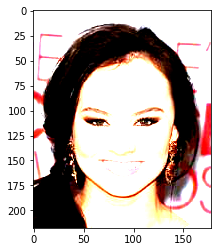

In [41]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

X, Y = iter(dlt).next()

show(X[Y==1][0])


In [42]:
X.shape

torch.Size([64, 3, 218, 178])

In [52]:

F.bce

ModuleNotFoundError: No module named 'pl'